In [1]:
import sys
sys.path.append("/Users/hhg/Research/c_lib/")
import illustris_python as il
import pandas as pd
from astropy.table import Table
import h5py

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run ../code/load_catalog.py

### 1. loading snapshot info

In [3]:
basePath = "/Users/hhg/Research/baryon_MassProfile/catalog/TNG100-3"
snap = 94
subsample_frac = 0.01

In [4]:
snap_info = TNGsnap_info(basePath, snap, subsample_frac)

loading snapshot ptl: dm
loading snapshot ptl: gas
loading snapshot ptl: star
loading snapshot ptl: bh


In [5]:
snap_info.snap_cat['pos'].shape

(1854735, 3)

In [6]:
snap_info.snap_cat['mass'].shape

(1854735,)

### 2. creating matched halo info

In [7]:
basePath_hydro = "/Users/hhg/Research/baryon_MassProfile/catalog/TNG100-3"
basePath_dmo = "/Users/hhg/Research/baryon_MassProfile/catalog/TNG100-3-dark"
snap = 94

log10_Mhalo_range = [14.0, 15.]

Cat = TNGmatched_groupCat(basePath_hydro, basePath_dmo, snap, log10_Mhalo_range)

available keys: <KeysViewHDF5 ['SubhaloIndexDark_LHaloTree', 'SubhaloIndexDark_SubLink']>


In [8]:
Cat.matched_halo_cat_hydro['GroupPos'].shape

(14, 3)

### 3. building correlation function

In [9]:
import treecorr
treecorr.__version__

'4.0.10'

In [10]:
factor_Nhalo=500
randoms1=np.random.uniform(0, 75000, size=(len(Cat.matched_halo_cat_hydro)*factor_Nhalo, 3))

factor_Nptl=1
randoms2=np.random.uniform(0, 75000, size=(len(snap_info.snap_cat['pos'])*factor_Nptl, 3))

randoms1=randoms2   # need more halo randoms to compute at very small scales.

In [11]:
#https://rmjarvis.github.io/TreeCorr/_build/html/catalog.html#the-catalog-class

halo_pos = Cat.matched_halo_cat_hydro['GroupPos']
halo_wt = Cat.matched_halo_cat_hydro['GroupMass']*1.
halo_wt /= halo_wt.max()

D1 = treecorr.Catalog(x=halo_pos[:,0], y=halo_pos[:,1], z=halo_pos[:,2], w=halo_wt)

ptl_pos = snap_info.snap_cat['pos']
ptl_wt = snap_info.snap_cat['mass']*1.
ptl_wt/=ptl_wt.max()

D2 = treecorr.Catalog(x=ptl_pos[:,0], y=ptl_pos[:,1], z=ptl_pos[:,2], w=ptl_wt)

R1 = treecorr.Catalog(x=randoms1[:,0], y=randoms1[:,1], z=randoms1[:,2])

R2 = treecorr.Catalog(x=randoms2[:,0], y=randoms2[:,1], z=randoms2[:,2])

In [12]:
#https://rmjarvis.github.io/TreeCorr/_build/html/nn.html


rmin=10. # [kpc/h]
rmax=3000

DD = treecorr.NNCorrelation(min_sep=rmin,max_sep=rmax,nbins=10) #match the units of r with units of position
DR = treecorr.NNCorrelation(min_sep=rmin,max_sep=rmax,nbins=10)
RR = treecorr.NNCorrelation(min_sep=rmin,max_sep=rmax,nbins=10)

RD = treecorr.NNCorrelation(min_sep=rmin,max_sep=rmax,nbins=10) 
#usually RD=DR


In [60]:
metric='Euclidean'  #distance defition. see https://rmjarvis.github.io/TreeCorr/_build/html/metric.html
%time DD.process(D1,D2, metric=metric)

CPU times: user 17.3 s, sys: 366 ms, total: 17.6 s
Wall time: 17.6 s


In [61]:
%time DR.process(D1,R2, metric=metric)

CPU times: user 16.8 s, sys: 216 ms, total: 17 s
Wall time: 17 s


In [62]:
%time RD.process(R1,D2, metric=metric)

CPU times: user 3min 56s, sys: 448 ms, total: 3min 56s
Wall time: 3min 57s


In [63]:
%time RR.process(R1,R2, metric=metric)

CPU times: user 6min 38s, sys: 315 ms, total: 6min 38s
Wall time: 6min 38s


In [65]:
xi,varxi = DD.calculateXi(RR, DR, RD)

In [66]:
DD.meanr  #center of r-bins

array([  14.05523938,   24.82606981,   43.758878  ,   77.04943726,
        136.27478277,  239.38737884,  420.95183666,  748.82126708,
       1296.62079284, 2318.63240231])

In [67]:
DD.npairs #pair count

array([  1769.,   3422.,   6883.,  15670.,  35407.,  74401., 132675.,
       198271., 240094., 245430.])

In [68]:
DR.npairs

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0000e+00,
       4.2000e+01, 1.6300e+02, 8.6600e+02, 4.8700e+03, 2.5312e+04])

In [69]:
RR.npairs

array([3.75600000e+03, 2.12900000e+04, 1.18726000e+05, 6.53544000e+05,
       3.61287000e+06, 1.99202220e+07, 1.10177862e+08, 6.07012442e+08,
       3.32233385e+09, 1.80129800e+10])

In [70]:
RD.npairs

array([3.84500000e+03, 2.13310000e+04, 1.17144000e+05, 6.53711000e+05,
       3.63499200e+06, 2.00111470e+07, 1.10251780e+08, 6.05310147e+08,
       3.30215267e+09, 1.78382789e+10])

In [71]:
xi

array([2.81015429e+05, 1.21440221e+05, 5.14007270e+04, 2.13039736e+04,
       8.06450185e+03, 2.93926972e+03, 8.85485487e+02, 2.41452319e+02,
       5.28134619e+01, 8.77328472e+00])

In [72]:
varxi

array([7.06546097e+02, 1.24649466e+02, 2.23521987e+01, 4.06060975e+00,
       7.34537125e-01, 1.33220761e-01, 2.40863917e-02, 4.37188261e-03,
       7.98771966e-04, 1.47326380e-04])

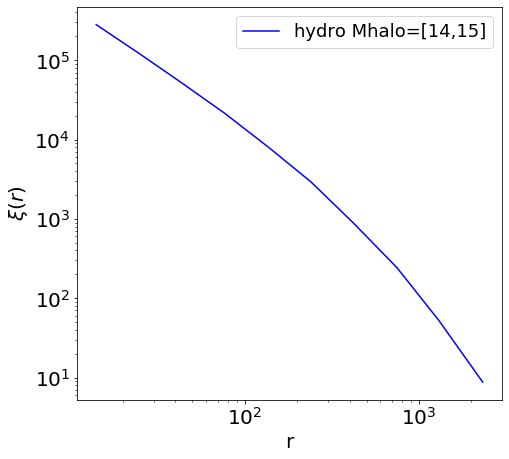

In [73]:
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(DD.meanr,xi,label='hydro Mhalo=[14,15]',color='blue')

ax1.set_xlabel('r')
ax1.set_ylabel(r'$\xi(r)$')

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.legend(loc='best',prop={'size':18})

### check periodic metrix

In [51]:
DD2 = treecorr.NNCorrelation(min_sep=rmin, max_sep=rmax, nbins=10, period=75000.)
DR2 = treecorr.NNCorrelation(min_sep=rmin, max_sep=rmax, nbins=10, period=75000.)
RR2 = treecorr.NNCorrelation(min_sep=rmin, max_sep=rmax, nbins=10, period=75000.)
RD2 = treecorr.NNCorrelation(min_sep=rmin, max_sep=rmax, nbins=10, period=75000.) 

In [54]:
%time DD2.process(D1,D2, metric='Periodic')

CPU times: user 12.8 ms, sys: 863 µs, total: 13.7 ms
Wall time: 12.4 ms


In [52]:
%time DR2.process(D1,R2, metric='Periodic')

CPU times: user 16.6 s, sys: 169 ms, total: 16.8 s
Wall time: 16.8 s


In [53]:
%time RD2.process(R1,D2, metric='Periodic')

CPU times: user 4min 19s, sys: 406 ms, total: 4min 19s
Wall time: 4min 20s


In [55]:
%time RR2.process(R1,R2, metric='Periodic')

CPU times: user 6min 54s, sys: 174 ms, total: 6min 54s
Wall time: 6min 54s


In [57]:
xi2,varxi2 = DD2.calculateXi(RR2, DR2, RD2)

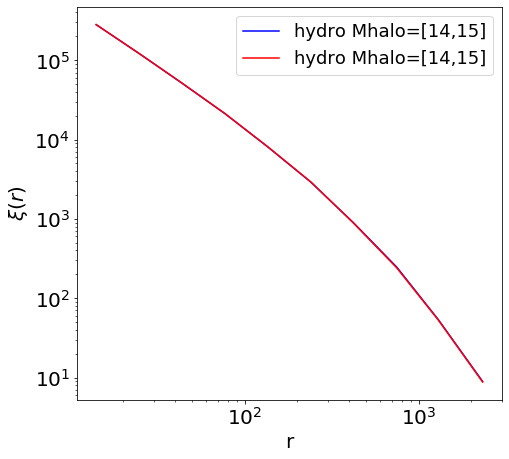

In [59]:
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(DD2.meanr,xi2,label='hydro Mhalo=[14,15]',color='blue')
ax1.plot(DD2.meanr,xi,label='hydro Mhalo=[14,15]',color='red')


ax1.set_xlabel('r')
ax1.set_ylabel(r'$\xi(r)$')

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.legend(loc='best',prop={'size':18})